In [1]:
import os
from glob import glob
import hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import ipynbname
import matplotlib.pyplot as plt
import shap
from datetime import datetime
import re

# Constants
EXPERIMENT_NAME = "nursing_home"
DATA_PATH = f"..{os.sep}data{os.sep}"

In [2]:
current_time = datetime.now()
print("Current time is:",current_time)

nb_fname = ipynbname.name()
print("File:",nb_fname)

experiment_number = int(re.findall(r'\d+', nb_fname)[0])
print(f"Experiment Number: {experiment_number}")  # Output: 01

Current time is: 2024-12-05 21:51:45.183085
File: machine_learning_experiment03
Experiment Number: 3


In [3]:
# Function to generate a consistent hash number for a given file name
def generate_hash_number(file_name):
    """
    Generates a consistent hash number based on the file name.
    
    Args:
        file_name (str): The file name to hash.
    
    Returns:
        int: A 32-bit hash number.
    """
    # Create an MD5 hash object
    hash_obj = hashlib.md5()
    
    # Update the hash object with the file name, encoded to bytes
    hash_obj.update(file_name.encode())

    # Convert the hash to an integer and ensure the range fits 32-bit
    return int(hash_obj.hexdigest(), 16) % (2**32)

# Generate experiment seed from experiment name
initial_seed = generate_hash_number(EXPERIMENT_NAME)
print(f"Experiment Name: {EXPERIMENT_NAME}, Initial Seed: {initial_seed}")

Experiment Name: nursing_home, Initial Seed: 127573839


In [4]:
# Set the seed for reproducibility
np.random.seed(initial_seed)

# Generate a list of 5 random integers in the range of 32-bit integers
random_integers_list = np.random.randint(low=0, high=2**31 - 1, size=10).tolist()
print("Random Integers List:", random_integers_list)
seed = random_integers_list[experiment_number-1]
# Load clinical microbiome data
df_path = glob(f'{DATA_PATH}*clinical_microbiome_df*')[0]
print(f"Data File Path: {df_path}")

clinical_microbiome_df = pd.read_csv(df_path)
print("Clinical Microbiome Data Loaded.")

# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)

print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)
print(f"Seed in this experiment: {seed}")

Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Data File Path: ../data/clinical_microbiome_df.csv
Clinical Microbiome Data Loaded.
Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64
Seed in this experiment: 1572185508


In [5]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [6]:
clinical_microbiome_df = clinical_microbiome_df[clinical_microbiome_df["Dementia Other"] != 1]
# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)
print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)

Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64


In [7]:
clinical_summaries_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}clinical_summaries_df*")[0])
clinical_summaries_df

,Feature,Description,Group Characteristics,Summary
0,Sample ID,Unique identifier for biological or clinical s...,Study Identification,### Clinical Feature Summary\n\n#### Feature: ...
1,study_id,Identifier for the specific study or research ...,Study Identification,"### Clinical Feature Definitions, Scope, and R..."
2,day,Day of data collection or relevant event.,Temporal Information,### Clinical Feature Summary for Alzheimer's D...
3,Date Sample,Date when the sample was collected.,Temporal Information,### Clinical Feature Summary\n\n#### Feature: ...
4,age,Age of the participant.,Demographic Information,### Clinical Feature Summary: Age\n\n**Definit...
...,...,...,...,...
98,Severe Liver disease,Advanced liver disease diagnosis.,Hepatic Condition,### Clinical Feature: Severe Liver Disease\n\n...
99,ostomy,Presence of an ostomy.,Surgical History,### Clinical Feature: Ostomy\n\n**Definition:*...
100,Alzheimers,Diagnosis of Alzheimer’s disease.,Neurological Condition,### Clinical Feature Summary: Alzheimer's Dise...
101,Dementia Other,Other forms of dementia.,Neurological Condition,### Clinical Feature: Dementia Other\n\n**Defi...


In [8]:
clinical_summaries_df['Feature'].tolist()[:5]

['Sample ID', 'study_id', 'day', 'Date Sample', 'age']

In [9]:
clinical_summaries_df[['Feature']][clinical_summaries_df['Feature'].str.startswith(('c', 'C'))]

,Feature
10,clinical_frailty_scale
16,cholinesterase inhibitors
17,Calcium-channel blockers
58,Calcium Channel Modulators
59,Carbonic Anhydrase Inhibitor
60,Carboxamides
71,Chemotherapy Medication
81,COPD
86,Congestive heart failure
88,Cerebrovascular disease: CVA with mild or no r...


In [10]:
bacteria_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}bacteria_df*")[0])
bacteria_df.species_name.tolist()[:5]

['Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Eubacterium_siraeum',
 'Gemmiger_formicilis',
 'Eubacterium_rectale']

In [11]:
set(bacteria_df.species_name.tolist()[:5])

{'Eubacterium_rectale',
 'Eubacterium_siraeum',
 'Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Gemmiger_formicilis'}

In [12]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [13]:
import os
from math import ceil
from pynvml import nvmlInit, nvmlDeviceGetCount

# Function to get the number of GPUs available
def get_num_gpus():
    try:
        nvmlInit()
        return nvmlDeviceGetCount()
    except Exception as e:
        print(f"Error accessing NVML: {e}")
        return 0

# Function to list all .ipynb files in the current directory
def get_notebook_files():
    return [f for f in os.listdir('.') if f.endswith('.ipynb')]

# Function to evenly distribute files across GPUs
def distribute_files_evenly(files, num_gpus):
    """
    Distributes files evenly across all available GPUs.
    
    Args:
        files (list): List of file names to distribute.
        num_gpus (int): Number of GPUs available.
        
    Returns:
        dict: Distribution of files per GPU.
    """
    distribution = {f"cuda:{i}": [] for i in range(num_gpus)}
    for idx, file in enumerate(files):
        # Assign each file to a GPU in round-robin fashion
        gpu_id = idx % num_gpus
        distribution[f"cuda:{gpu_id}"].append(file)
    return distribution

# Function to get GPU ID for a specific notebook file
def get_gpu_for_file(nb_fname, file_distribution):
    """
    Finds the GPU ID for a given notebook file based on the distribution.
    
    Args:
        nb_fname (str): Notebook file name to find the GPU for.
        file_distribution (dict): Distribution of files per GPU.
    
    Returns:
        str: GPU ID (e.g., "cuda:0") or "Unassigned" if the file is not found.
    """
    for gpu, files in file_distribution.items():
        if nb_fname in files:
            return gpu
    return "cpu"

# Main logic for the notebook
def assign_notebooks_to_gpus():
    # Get the number of GPUs
    num_gpus = get_num_gpus()
    if num_gpus == 0:
        print("No GPUs available. Using CPU for all tasks.")
        return {"cpu": get_notebook_files()}
    
    # Get the list of .ipynb files
    notebook_files = get_notebook_files()
    if not notebook_files:
        print("No .ipynb files found in the current directory.")
        return {}
    
    # Evenly distribute files across GPUs
    file_distribution = distribute_files_evenly(notebook_files, num_gpus)
    
    # Display the distribution in the notebook
    for gpu, files in file_distribution.items():
        print(f"{gpu}: {files}")
    
    return file_distribution

# Run the assignment logic
file_distribution = assign_notebooks_to_gpus()

# Get the GPU ID for the specific notebook file
device = get_gpu_for_file(f"{nb_fname}.ipynb", file_distribution)

print(f"Initial seed: {initial_seed}")
print(f"Random Integers List: {random_integers_list}")
# Print the result
print(f"Notebook '{nb_fname}.ipynb' is assigned to device: {device} with seed {seed}.")

cuda:0: ['machine_learning_experiment03.ipynb', 'machine_learning_experiment06.ipynb', 'machine_learning_experiment08.ipynb']
cuda:1: ['machine_learning_experiment09.ipynb', 'machine_learning_experiment07.ipynb', 'machine_learning_experiment10.ipynb']
cuda:2: ['machine_learning_experiment02.ipynb', 'machine_learning_experiment04.ipynb']
cuda:3: ['machine_learning_experiment05.ipynb', 'machine_learning_experiment01.ipynb']
Initial seed: 127573839
Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Notebook 'machine_learning_experiment03.ipynb' is assigned to device: cuda:0 with seed 1572185508.


Experiment number: 3 | Seed number: 1572185508
No overlap Study ID found.
No overlap Sample ID found.


[I 2024-12-05 21:51:46,029] A new study created in memory with name: no-name-6ede96ca-c60e-4068-84ec-5d762e69b9cd


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:51:47,334] Trial 0 finished with value: 0.7588422262798403 and parameters: {'threshold': '0.5*mean', 'max_features': 589, 'norm_order': 2, 'learning_rate': 0.46078247258098576, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.8504178408457188, 'colsample_bytree': 0.6349340027229666, 'gamma': 6.262668106137958, 'reg_alpha': 1.8942843605029203, 'reg_lambda': 3.6511908678664606, 'n_estimators': 174}. Best is trial 0 with value: 0.7588422262798403.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:51:48,161] Trial 1 finished with value: 0.7390527667567516 and parameters: {'threshold': '0.5*mean', 'max_features': 473, 'norm_order': 2, 'learning_rate': 0.32662578651471263, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9439141335485901, 'colsample_bytree': 0.682764048226356, 'gamma': 3.945197686207693, 'reg_alpha': 1.7919810630130462, 'reg_lambda': 6.1866429868568815, 'n_estimators': 92}. Best is trial 0 with value: 0.7588422262798403.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:51:49,225] Trial 2 finished with value: 0.7065472567602818 and parameters: {'threshold': 'very_low', 'max_features': 712, 'norm_order': 2, 'learning_rate': 0.29327367131844895, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.5082756030000722, 'colsample_bytree': 0.8227447201655056, 'gamma': 7.467628670072257, 'reg_alpha': 0.12869931510408605, 'reg_lambda': 0.6342293169733881, 'n_estimators': 257}. Best is trial 0 with value: 0.7588422262798403.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:51:50,308] Trial 3 finished with value: 0.7291666666666666 and parameters: {'threshold': 'mean', 'max_features': 466, 'norm_order': 1, 'learning_rate': 0.47508239581842804, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.7589616346145117, 'colsample_bytree': 0.8163493675057573, 'gamma': 2.0364084228749757, 'reg_alpha': 6.638506178474679, 'reg_lambda': 5.953753278341435, 'n_estimators': 258}. Best is trial 0 with value: 0.7588422262798403.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:51:51,241] Trial 4 finished with value: 0.8242424242424242 and parameters: {'threshold': '0.5*mean', 'max_features': 515, 'norm_order': 1, 'learning_rate': 0.26876316183923754, 'max_depth': 14, 'min_child_weight': 3, 'subsample': 0.6979700339618395, 'colsample_bytree': 0.5664720914231199, 'gamma': 2.611064343063706, 'reg_alpha': 1.8435976182129887, 'reg_lambda': 7.917399494602867, 'n_estimators': 117}. Best is trial 4 with value: 0.8242424242424242.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:51:52,503] Trial 5 finished with value: 0.691005291005291 and parameters: {'threshold': 'median', 'max_features': 58, 'norm_order': 2, 'learning_rate': 0.26000561636119424, 'max_depth': 25, 'min_child_weight': 8, 'subsample': 0.7720876094210678, 'colsample_bytree': 0.5112379135328446, 'gamma': 7.054055370961371, 'reg_alpha': 6.190119279212393, 'reg_lambda': 1.9339909549561585, 'n_estimators': 166}. Best is trial 4 with value: 0.8242424242424242.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:51:54,114] Trial 6 finished with value: 0.6556671310270102 and parameters: {'threshold': '0.5*mean', 'max_features': 592, 'norm_order': 1, 'learning_rate': 0.02881337653778935, 'max_depth': 19, 'min_child_weight': 7, 'subsample': 0.5490595300861851, 'colsample_bytree': 0.9068357405607863, 'gamma': 7.246959344118532, 'reg_alpha': 6.255814789879946, 'reg_lambda': 6.258276174722299, 'n_estimators': 226}. Best is trial 4 with value: 0.8242424242424242.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:51:55,179] Trial 7 finished with value: 0.7824508824508825 and parameters: {'threshold': 'median', 'max_features': 935, 'norm_order': 2, 'learning_rate': 0.3247755110525368, 'max_depth': 20, 'min_child_weight': 8, 'subsample': 0.9014473317769607, 'colsample_bytree': 0.7157498217899342, 'gamma': 0.871584198469898, 'reg_alpha': 1.5368622482794136, 'reg_lambda': 3.7360783362661087, 'n_estimators': 211}. Best is trial 4 with value: 0.8242424242424242.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:51:56,373] Trial 8 finished with value: 0.7277392939608179 and parameters: {'threshold': 'very_low', 'max_features': 172, 'norm_order': 2, 'learning_rate': 0.29915754143534645, 'max_depth': 24, 'min_child_weight': 1, 'subsample': 0.5358846892824733, 'colsample_bytree': 0.8397905989973392, 'gamma': 8.542126546065695, 'reg_alpha': 3.126623225860988, 'reg_lambda': 4.95506907226914, 'n_estimators': 236}. Best is trial 4 with value: 0.8242424242424242.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:51:57,432] Trial 9 finished with value: 0.7048281678262702 and parameters: {'threshold': 'very_low', 'max_features': 852, 'norm_order': 1, 'learning_rate': 0.303353811877727, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.9389440446869215, 'colsample_bytree': 0.6628694491185391, 'gamma': 4.092083644227991, 'reg_alpha': 6.000686870134182, 'reg_lambda': 0.36751232955122837, 'n_estimators': 97}. Best is trial 4 with value: 0.8242424242424242.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:51:58,372] Trial 10 finished with value: 0.6997454751131222 and parameters: {'threshold': '1.5*mean', 'max_features': 287, 'norm_order': 1, 'learning_rate': 0.12064071705739701, 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.6507804381037514, 'colsample_bytree': 0.5022967113339833, 'gamma': 2.457023818008651, 'reg_alpha': 9.731657462168055, 'reg_lambda': 9.64921562026003, 'n_estimators': 52}. Best is trial 4 with value: 0.8242424242424242.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:00,396] Trial 11 finished with value: 0.7672878520308579 and parameters: {'threshold': 'median', 'max_features': 869, 'norm_order': 1, 'learning_rate': 0.1726030565797169, 'max_depth': 16, 'min_child_weight': 5, 'subsample': 0.6581570749391407, 'colsample_bytree': 0.5950966161509795, 'gamma': 0.392301302923814, 'reg_alpha': 3.7126641697716893, 'reg_lambda': 8.969536026259462, 'n_estimators': 144}. Best is trial 4 with value: 0.8242424242424242.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:02,337] Trial 12 finished with value: 0.8378373776074927 and parameters: {'threshold': 'median', 'max_features': 1029, 'norm_order': 2, 'learning_rate': 0.3619099607604256, 'max_depth': 13, 'min_child_weight': 3, 'subsample': 0.8465552222092035, 'colsample_bytree': 0.9890591130177397, 'gamma': 0.8131981568361422, 'reg_alpha': 0.1274806301180318, 'reg_lambda': 7.992152211761081, 'n_estimators': 206}. Best is trial 12 with value: 0.8378373776074927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:04,989] Trial 13 finished with value: 0.811111111111111 and parameters: {'threshold': '1.5*mean', 'max_features': 382, 'norm_order': 1, 'learning_rate': 0.39824231724770043, 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.8162343644665212, 'colsample_bytree': 0.9986073928152156, 'gamma': 2.5254551490222656, 'reg_alpha': 0.11464059899070378, 'reg_lambda': 8.179740666454897, 'n_estimators': 295}. Best is trial 12 with value: 0.8378373776074927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:07,811] Trial 14 finished with value: 0.8170554376384341 and parameters: {'threshold': 'mean', 'max_features': 728, 'norm_order': 2, 'learning_rate': 0.18061103261461925, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.6742353163641938, 'colsample_bytree': 0.9938440620645139, 'gamma': 1.533843024436337, 'reg_alpha': 3.37652799553957, 'reg_lambda': 7.823955333631422, 'n_estimators': 128}. Best is trial 12 with value: 0.8378373776074927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:10,819] Trial 15 finished with value: 0.7760806628731157 and parameters: {'threshold': '0.5*mean', 'max_features': 1042, 'norm_order': 1, 'learning_rate': 0.39101613223844567, 'max_depth': 29, 'min_child_weight': 6, 'subsample': 0.7037896119503471, 'colsample_bytree': 0.5670079800735014, 'gamma': 3.568152495907083, 'reg_alpha': 1.2173787238709592, 'reg_lambda': 7.273534416089397, 'n_estimators': 198}. Best is trial 12 with value: 0.8378373776074927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:14,843] Trial 16 finished with value: 0.811074621419449 and parameters: {'threshold': 'median', 'max_features': 705, 'norm_order': 1, 'learning_rate': 0.38973565929213105, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.6018376123445546, 'colsample_bytree': 0.7642090123694498, 'gamma': 0.04905912575205473, 'reg_alpha': 4.610057582280795, 'reg_lambda': 9.503389269821575, 'n_estimators': 119}. Best is trial 12 with value: 0.8378373776074927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:17,628] Trial 17 finished with value: 0.6267051837586263 and parameters: {'threshold': '0.5*mean', 'max_features': 318, 'norm_order': 2, 'learning_rate': 0.214650610005641, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.846821082702337, 'colsample_bytree': 0.9173444464595939, 'gamma': 5.3685358439087345, 'reg_alpha': 8.37612904067208, 'reg_lambda': 7.054077039456836, 'n_estimators': 67}. Best is trial 12 with value: 0.8378373776074927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:20,587] Trial 18 finished with value: 0.7324163496244269 and parameters: {'threshold': 'median', 'max_features': 1034, 'norm_order': 2, 'learning_rate': 0.10406524426254715, 'max_depth': 19, 'min_child_weight': 5, 'subsample': 0.9884820455395409, 'colsample_bytree': 0.7437103731341207, 'gamma': 3.1405332578313403, 'reg_alpha': 2.5093481807877414, 'reg_lambda': 8.39135694655843, 'n_estimators': 152}. Best is trial 12 with value: 0.8378373776074927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:24,882] Trial 19 finished with value: 0.7399671951886276 and parameters: {'threshold': '1.5*mean', 'max_features': 592, 'norm_order': 1, 'learning_rate': 0.3613544189953674, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.7129689583369774, 'colsample_bytree': 0.9237496295577166, 'gamma': 9.96683955630171, 'reg_alpha': 0.8460272807400928, 'reg_lambda': 4.85990106291499, 'n_estimators': 193}. Best is trial 12 with value: 0.8378373776074927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:28,500] Trial 20 finished with value: 0.7687991021324354 and parameters: {'threshold': 'mean', 'max_features': 780, 'norm_order': 1, 'learning_rate': 0.24576283102288154, 'max_depth': 15, 'min_child_weight': 4, 'subsample': 0.8062403907796993, 'colsample_bytree': 0.5682818474700552, 'gamma': 1.2728690634739843, 'reg_alpha': 4.93844760151729, 'reg_lambda': 6.849042097282208, 'n_estimators': 103}. Best is trial 12 with value: 0.8378373776074927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:31,811] Trial 21 finished with value: 0.8289562289562289 and parameters: {'threshold': 'mean', 'max_features': 695, 'norm_order': 2, 'learning_rate': 0.1696711863626989, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.7008760350282485, 'colsample_bytree': 0.9950774126192137, 'gamma': 1.5649882784893168, 'reg_alpha': 3.9277497299046593, 'reg_lambda': 7.925815155238985, 'n_estimators': 128}. Best is trial 12 with value: 0.8378373776074927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:36,827] Trial 22 finished with value: 0.7827970548753204 and parameters: {'threshold': 'mean', 'max_features': 532, 'norm_order': 2, 'learning_rate': 0.130681336095771, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.6065690719759931, 'colsample_bytree': 0.9631216716752025, 'gamma': 1.6542289854960932, 'reg_alpha': 4.060386340082805, 'reg_lambda': 8.46394734673061, 'n_estimators': 130}. Best is trial 12 with value: 0.8378373776074927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:40,774] Trial 23 finished with value: 0.7708604954367666 and parameters: {'threshold': 'mean', 'max_features': 918, 'norm_order': 2, 'learning_rate': 0.07033390640495948, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.723386316234366, 'colsample_bytree': 0.8702300425895252, 'gamma': 5.022866699157282, 'reg_alpha': 2.3394018838107247, 'reg_lambda': 7.468013183927494, 'n_estimators': 80}. Best is trial 12 with value: 0.8378373776074927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:44,903] Trial 24 finished with value: 0.8681818181818182 and parameters: {'threshold': 'mean', 'max_features': 392, 'norm_order': 2, 'learning_rate': 0.20773542610757828, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.7913279821901005, 'colsample_bytree': 0.9537808734838893, 'gamma': 0.9023660271313703, 'reg_alpha': 0.8102254288692734, 'reg_lambda': 9.83011502878624, 'n_estimators': 160}. Best is trial 24 with value: 0.8681818181818182.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:49,482] Trial 25 finished with value: 0.8891388530333764 and parameters: {'threshold': 'mean', 'max_features': 172, 'norm_order': 2, 'learning_rate': 0.19942189657221063, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.8779104918804296, 'colsample_bytree': 0.9477861847949244, 'gamma': 0.6771545378185275, 'reg_alpha': 0.5534225257979877, 'reg_lambda': 9.602704805032552, 'n_estimators': 156}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:53,172] Trial 26 finished with value: 0.8267651888341544 and parameters: {'threshold': 'mean', 'max_features': 173, 'norm_order': 2, 'learning_rate': 0.24032319196228558, 'max_depth': 21, 'min_child_weight': 6, 'subsample': 0.8803897701238601, 'colsample_bytree': 0.9516943790162485, 'gamma': 0.9725981434061122, 'reg_alpha': 0.7058033362616856, 'reg_lambda': 9.98644775099009, 'n_estimators': 191}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:52:56,275] Trial 27 finished with value: 0.7215818664094527 and parameters: {'threshold': 'mean', 'max_features': 14, 'norm_order': 2, 'learning_rate': 0.2045084975624246, 'max_depth': 23, 'min_child_weight': 4, 'subsample': 0.7931284138920167, 'colsample_bytree': 0.8685043605092191, 'gamma': 0.16474691605060876, 'reg_alpha': 0.6786312310515381, 'reg_lambda': 8.858972806164696, 'n_estimators': 160}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:00,053] Trial 28 finished with value: 0.7865097573689157 and parameters: {'threshold': 'median', 'max_features': 179, 'norm_order': 2, 'learning_rate': 0.4326355929553348, 'max_depth': 17, 'min_child_weight': 5, 'subsample': 0.8973981897281588, 'colsample_bytree': 0.9502100252427167, 'gamma': 0.7506584955335506, 'reg_alpha': 2.643306276773834, 'reg_lambda': 9.029284062889529, 'n_estimators': 181}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:04,004] Trial 29 finished with value: 0.8074456532874382 and parameters: {'threshold': 'mean', 'max_features': 271, 'norm_order': 2, 'learning_rate': 0.34568514671985073, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.8481732187349666, 'colsample_bytree': 0.8903469108669836, 'gamma': 3.2515020845243106, 'reg_alpha': 0.14467419431041773, 'reg_lambda': 9.420760554747732, 'n_estimators': 171}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:08,175] Trial 30 finished with value: 0.7712291481391652 and parameters: {'threshold': 'mean', 'max_features': 393, 'norm_order': 2, 'learning_rate': 0.21650438231054964, 'max_depth': 27, 'min_child_weight': 2, 'subsample': 0.8379427147648911, 'colsample_bytree': 0.9599910497912485, 'gamma': 6.028771127153714, 'reg_alpha': 1.303264603099472, 'reg_lambda': 3.7545122174522554, 'n_estimators': 214}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:12,334] Trial 31 finished with value: 0.8310886644219977 and parameters: {'threshold': 'mean', 'max_features': 226, 'norm_order': 2, 'learning_rate': 0.1631466666522617, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.7459545363212811, 'colsample_bytree': 0.9973566660320082, 'gamma': 1.6900415207493231, 'reg_alpha': 1.0465201644023923, 'reg_lambda': 9.972790962468933, 'n_estimators': 136}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:16,060] Trial 32 finished with value: 0.8531632110579478 and parameters: {'threshold': 'mean', 'max_features': 122, 'norm_order': 2, 'learning_rate': 0.13497565754098195, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7461217222437009, 'colsample_bytree': 0.9369438390418883, 'gamma': 2.0107521053615436, 'reg_alpha': 0.9026646591653751, 'reg_lambda': 9.942671910630215, 'n_estimators': 144}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:19,490] Trial 33 finished with value: 0.7659045934908004 and parameters: {'threshold': 'mean', 'max_features': 78, 'norm_order': 2, 'learning_rate': 0.06732645367469842, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8775218860922195, 'colsample_bytree': 0.9351536647960557, 'gamma': 4.249199569280081, 'reg_alpha': 2.078263512141038, 'reg_lambda': 9.059073005547168, 'n_estimators': 152}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:23,299] Trial 34 finished with value: 0.8516894087069525 and parameters: {'threshold': 'very_low', 'max_features': 102, 'norm_order': 2, 'learning_rate': 0.1370997993526469, 'max_depth': 22, 'min_child_weight': 4, 'subsample': 0.9447158086514758, 'colsample_bytree': 0.8876585549558696, 'gamma': 0.6224069016271607, 'reg_alpha': 0.10305327583924531, 'reg_lambda': 8.613594315156591, 'n_estimators': 180}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:27,785] Trial 35 finished with value: 0.8027503445320091 and parameters: {'threshold': 'very_low', 'max_features': 118, 'norm_order': 2, 'learning_rate': 0.14338939225923553, 'max_depth': 23, 'min_child_weight': 4, 'subsample': 0.9890106737289283, 'colsample_bytree': 0.8002947207797049, 'gamma': 2.156338073904587, 'reg_alpha': 0.6742986778886395, 'reg_lambda': 8.664834657678592, 'n_estimators': 176}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:32,142] Trial 36 finished with value: 0.8398257331245539 and parameters: {'threshold': 'very_low', 'max_features': 102, 'norm_order': 2, 'learning_rate': 0.09362300281917091, 'max_depth': 21, 'min_child_weight': 4, 'subsample': 0.9455913833651342, 'colsample_bytree': 0.8597607172894149, 'gamma': 0.4179230731241175, 'reg_alpha': 1.8005660185346912, 'reg_lambda': 9.984195754408493, 'n_estimators': 180}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:35,495] Trial 37 finished with value: 0.8103648073834897 and parameters: {'threshold': 'very_low', 'max_features': 32, 'norm_order': 2, 'learning_rate': 0.19606311980401253, 'max_depth': 18, 'min_child_weight': 5, 'subsample': 0.9350241613489269, 'colsample_bytree': 0.8891098954102804, 'gamma': 2.045377380844544, 'reg_alpha': 2.7317344689036402, 'reg_lambda': 1.5015443834837585, 'n_estimators': 160}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:41,151] Trial 38 finished with value: 0.8360130336958473 and parameters: {'threshold': 'very_low', 'max_features': 372, 'norm_order': 2, 'learning_rate': 0.015965153384153538, 'max_depth': 26, 'min_child_weight': 3, 'subsample': 0.7708046343348537, 'colsample_bytree': 0.7853308640950073, 'gamma': 1.0981116737498082, 'reg_alpha': 1.6889160634176683, 'reg_lambda': 5.678352037402657, 'n_estimators': 243}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:44,415] Trial 39 finished with value: 0.7380952380952381 and parameters: {'threshold': 'mean', 'max_features': 221, 'norm_order': 2, 'learning_rate': 0.14822631461210722, 'max_depth': 22, 'min_child_weight': 1, 'subsample': 0.9638441292984221, 'colsample_bytree': 0.8304116232414456, 'gamma': 2.813817025019322, 'reg_alpha': 7.5124527791215305, 'reg_lambda': 9.281462339382891, 'n_estimators': 140}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:48,180] Trial 40 finished with value: 0.849712617736451 and parameters: {'threshold': 'very_low', 'max_features': 452, 'norm_order': 2, 'learning_rate': 0.07724942297750904, 'max_depth': 19, 'min_child_weight': 4, 'subsample': 0.9070822508055083, 'colsample_bytree': 0.9059343756150964, 'gamma': 0.5903158767469227, 'reg_alpha': 0.5002527409685429, 'reg_lambda': 6.398722767684033, 'n_estimators': 116}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:51,827] Trial 41 finished with value: 0.8520829453032843 and parameters: {'threshold': 'very_low', 'max_features': 459, 'norm_order': 2, 'learning_rate': 0.0548043488190332, 'max_depth': 20, 'min_child_weight': 4, 'subsample': 0.9172121985977079, 'colsample_bytree': 0.9026207148220424, 'gamma': 0.4542158459646052, 'reg_alpha': 0.5273125877071148, 'reg_lambda': 6.19211140097489, 'n_estimators': 114}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:55,934] Trial 42 finished with value: 0.8316623559752166 and parameters: {'threshold': 'very_low', 'max_features': 124, 'norm_order': 2, 'learning_rate': 0.04536793662166229, 'max_depth': 20, 'min_child_weight': 3, 'subsample': 0.8706593925267238, 'colsample_bytree': 0.9409641776122472, 'gamma': 0.04675317003267154, 'reg_alpha': 1.3883313171413552, 'reg_lambda': 4.453767417188968, 'n_estimators': 105}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:53:59,987] Trial 43 finished with value: 0.8428670654925948 and parameters: {'threshold': 'very_low', 'max_features': 539, 'norm_order': 2, 'learning_rate': 0.10995368597965499, 'max_depth': 18, 'min_child_weight': 4, 'subsample': 0.9639795201199861, 'colsample_bytree': 0.9681001934840748, 'gamma': 1.0801406574606744, 'reg_alpha': 0.38507999944065174, 'reg_lambda': 3.0111584045096507, 'n_estimators': 83}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:03,983] Trial 44 finished with value: 0.8122389306599832 and parameters: {'threshold': 'very_low', 'max_features': 430, 'norm_order': 2, 'learning_rate': 0.2779666897784757, 'max_depth': 24, 'min_child_weight': 6, 'subsample': 0.9220191721320716, 'colsample_bytree': 0.8541154478554416, 'gamma': 1.953224496860595, 'reg_alpha': 0.00692308939489672, 'reg_lambda': 9.605590151684666, 'n_estimators': 150}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:07,744] Trial 45 finished with value: 0.8577945176815233 and parameters: {'threshold': '1.5*mean', 'max_features': 332, 'norm_order': 2, 'learning_rate': 0.14556679804840686, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7877832202842069, 'colsample_bytree': 0.895765568837811, 'gamma': 0.5574269137886674, 'reg_alpha': 1.1732913131357914, 'reg_lambda': 5.609170111828363, 'n_estimators': 167}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:12,009] Trial 46 finished with value: 0.8378280676515613 and parameters: {'threshold': '1.5*mean', 'max_features': 340, 'norm_order': 2, 'learning_rate': 0.4978770357821622, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7546121193319517, 'colsample_bytree': 0.9077155723705953, 'gamma': 1.34118849920997, 'reg_alpha': 2.023698778398746, 'reg_lambda': 5.631326587669438, 'n_estimators': 165}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:15,958] Trial 47 finished with value: 0.7151874600065135 and parameters: {'threshold': '1.5*mean', 'max_features': 497, 'norm_order': 2, 'learning_rate': 0.04664544124293521, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.79270342802048, 'colsample_bytree': 0.9689125159764405, 'gamma': 7.8842123922744625, 'reg_alpha': 1.0881490584244384, 'reg_lambda': 6.567855809013979, 'n_estimators': 111}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:19,638] Trial 48 finished with value: 0.7573587286718836 and parameters: {'threshold': '1.5*mean', 'max_features': 245, 'norm_order': 2, 'learning_rate': 0.22743086473541282, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8227818498562196, 'colsample_bytree': 0.9337999958014865, 'gamma': 2.3414632039911263, 'reg_alpha': 3.076549433178379, 'reg_lambda': 4.3629563789614405, 'n_estimators': 142}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:23,218] Trial 49 finished with value: 0.8852733686067019 and parameters: {'threshold': '1.5*mean', 'max_features': 302, 'norm_order': 2, 'learning_rate': 0.1802951919488212, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7274785902062186, 'colsample_bytree': 0.813470908562567, 'gamma': 0.4770273463269004, 'reg_alpha': 1.5602080989024023, 'reg_lambda': 5.834284664705053, 'n_estimators': 94}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:26,363] Trial 50 finished with value: 0.7615429573348919 and parameters: {'threshold': '1.5*mean', 'max_features': 306, 'norm_order': 2, 'learning_rate': 0.1881743769534222, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.7303755177112708, 'colsample_bytree': 0.7178978683369371, 'gamma': 1.848865717792169, 'reg_alpha': 1.6833708290995704, 'reg_lambda': 2.70058574139393, 'n_estimators': 93}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:30,103] Trial 51 finished with value: 0.8661018790051048 and parameters: {'threshold': '1.5*mean', 'max_features': 427, 'norm_order': 2, 'learning_rate': 0.27062860888884366, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.6724756985317707, 'colsample_bytree': 0.814669575988104, 'gamma': 0.4062377519050494, 'reg_alpha': 1.051721336279527, 'reg_lambda': 5.3817548997463085, 'n_estimators': 123}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:34,499] Trial 52 finished with value: 0.8274591796097172 and parameters: {'threshold': '1.5*mean', 'max_features': 343, 'norm_order': 2, 'learning_rate': 0.2788102088547299, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.6746369542526157, 'colsample_bytree': 0.8142038627520352, 'gamma': 0.9113731987190546, 'reg_alpha': 1.36571385507421, 'reg_lambda': 5.553167059889395, 'n_estimators': 125}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:37,710] Trial 53 finished with value: 0.8651905795235818 and parameters: {'threshold': '1.5*mean', 'max_features': 405, 'norm_order': 2, 'learning_rate': 0.2623512383890041, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6813821186491338, 'colsample_bytree': 0.8417029084089149, 'gamma': 0.042695868800647685, 'reg_alpha': 2.2472408801154, 'reg_lambda': 4.690159192825561, 'n_estimators': 62}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:41,126] Trial 54 finished with value: 0.8842787357186562 and parameters: {'threshold': '1.5*mean', 'max_features': 378, 'norm_order': 2, 'learning_rate': 0.3175446911440091, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6254833869111837, 'colsample_bytree': 0.7812688188695598, 'gamma': 0.004761539339777077, 'reg_alpha': 2.319588953883015, 'reg_lambda': 5.191900000783776, 'n_estimators': 66}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:44,176] Trial 55 finished with value: 0.8475566113877595 and parameters: {'threshold': '1.5*mean', 'max_features': 411, 'norm_order': 2, 'learning_rate': 0.3181254531994513, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6085061670217438, 'colsample_bytree': 0.7390203602436906, 'gamma': 0.05066937824815382, 'reg_alpha': 2.9828764051096806, 'reg_lambda': 5.173856078773599, 'n_estimators': 51}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:48,219] Trial 56 finished with value: 0.8533082386681903 and parameters: {'threshold': '1.5*mean', 'max_features': 282, 'norm_order': 2, 'learning_rate': 0.2625869267729865, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6580477376408856, 'colsample_bytree': 0.7830522482155133, 'gamma': 1.2869056781389792, 'reg_alpha': 2.240057840990634, 'reg_lambda': 4.025144322699198, 'n_estimators': 77}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:51,900] Trial 57 finished with value: 0.8323484623217006 and parameters: {'threshold': '1.5*mean', 'max_features': 616, 'norm_order': 2, 'learning_rate': 0.3034968217468341, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.6379114123792322, 'colsample_bytree': 0.654163671457908, 'gamma': 0.005558738993782564, 'reg_alpha': 5.709002591264943, 'reg_lambda': 4.8728104026987875, 'n_estimators': 62}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:55,962] Trial 58 finished with value: 0.8598001434696295 and parameters: {'threshold': '1.5*mean', 'max_features': 492, 'norm_order': 2, 'learning_rate': 0.2378838621684948, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.5745077352317891, 'colsample_bytree': 0.7593023176463077, 'gamma': 0.3427104028504574, 'reg_alpha': 3.503760314556605, 'reg_lambda': 5.196655740723968, 'n_estimators': 61}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:54:59,386] Trial 59 finished with value: 0.8047277015437393 and parameters: {'threshold': '0.5*mean', 'max_features': 370, 'norm_order': 2, 'learning_rate': 0.25813035576484533, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.6771874973998584, 'colsample_bytree': 0.8436215746380247, 'gamma': 0.7362010081828841, 'reg_alpha': 4.386654616131899, 'reg_lambda': 2.790928762288683, 'n_estimators': 70}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:03,322] Trial 60 finished with value: 0.8543209876543211 and parameters: {'threshold': '1.5*mean', 'max_features': 202, 'norm_order': 2, 'learning_rate': 0.28682989938182274, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.6891586012308324, 'colsample_bytree': 0.8094450950265412, 'gamma': 1.260235121047204, 'reg_alpha': 1.9628442257580394, 'reg_lambda': 3.292755004149052, 'n_estimators': 88}. Best is trial 25 with value: 0.8891388530333764.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:07,141] Trial 61 finished with value: 0.8937092202628927 and parameters: {'threshold': '1.5*mean', 'max_features': 494, 'norm_order': 2, 'learning_rate': 0.2457348187795751, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.5524446611274049, 'colsample_bytree': 0.7567928609714325, 'gamma': 0.23846664144695326, 'reg_alpha': 2.477175413697284, 'reg_lambda': 5.213688855395413, 'n_estimators': 64}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:11,052] Trial 62 finished with value: 0.8692014484467315 and parameters: {'threshold': '1.5*mean', 'max_features': 547, 'norm_order': 2, 'learning_rate': 0.2237701720994899, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5200355033432054, 'colsample_bytree': 0.7006668573391787, 'gamma': 0.31485754016082246, 'reg_alpha': 2.4157279438234864, 'reg_lambda': 4.373408687966386, 'n_estimators': 72}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:14,787] Trial 63 finished with value: 0.8692423291293347 and parameters: {'threshold': '1.5*mean', 'max_features': 617, 'norm_order': 2, 'learning_rate': 0.21567567622121872, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.5308798878675648, 'colsample_bytree': 0.6997695301842792, 'gamma': 0.9226250926830718, 'reg_alpha': 2.6611161331745046, 'reg_lambda': 5.910956167179221, 'n_estimators': 100}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:17,989] Trial 64 finished with value: 0.8172612501023302 and parameters: {'threshold': '1.5*mean', 'max_features': 557, 'norm_order': 2, 'learning_rate': 0.21828565246010523, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5003558847493167, 'colsample_bytree': 0.6915443365236801, 'gamma': 1.4428591669920183, 'reg_alpha': 2.624355282962193, 'reg_lambda': 5.962933427104602, 'n_estimators': 74}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:22,136] Trial 65 finished with value: 0.8540788569037155 and parameters: {'threshold': '1.5*mean', 'max_features': 649, 'norm_order': 2, 'learning_rate': 0.20092110302230876, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.5284140477645927, 'colsample_bytree': 0.7006946199489149, 'gamma': 0.9087886738423311, 'reg_alpha': 1.6710182298965917, 'reg_lambda': 4.18513116276467, 'n_estimators': 100}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:25,300] Trial 66 finished with value: 0.8269261727679577 and parameters: {'threshold': '0.5*mean', 'max_features': 572, 'norm_order': 2, 'learning_rate': 0.16522777023390953, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.5653444939648063, 'colsample_bytree': 0.6163739471431686, 'gamma': 0.7578831560428079, 'reg_alpha': 3.0100519147653975, 'reg_lambda': 7.603162923384489, 'n_estimators': 86}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:29,093] Trial 67 finished with value: 0.8153021442495126 and parameters: {'threshold': '1.5*mean', 'max_features': 602, 'norm_order': 2, 'learning_rate': 0.1791102976866894, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.5238354919347501, 'colsample_bytree': 0.725829319924433, 'gamma': 1.6063381690264342, 'reg_alpha': 3.422058725862655, 'reg_lambda': 5.981634613580493, 'n_estimators': 285}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:32,903] Trial 68 finished with value: 0.757076806440935 and parameters: {'threshold': '1.5*mean', 'max_features': 665, 'norm_order': 1, 'learning_rate': 0.23499151844551305, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.5496687973461829, 'colsample_bytree': 0.6643107115783152, 'gamma': 2.7440714065914373, 'reg_alpha': 2.67735191324216, 'reg_lambda': 6.785088497095253, 'n_estimators': 93}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:36,501] Trial 69 finished with value: 0.7296768943754217 and parameters: {'threshold': 'median', 'max_features': 522, 'norm_order': 2, 'learning_rate': 0.24802066010953555, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.5913038811186834, 'colsample_bytree': 0.6731347238867302, 'gamma': 4.461297678531365, 'reg_alpha': 4.061336650204504, 'reg_lambda': 4.608995982225615, 'n_estimators': 57}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:39,974] Trial 70 finished with value: 0.7405934343434343 and parameters: {'threshold': '1.5*mean', 'max_features': 480, 'norm_order': 2, 'learning_rate': 0.21320666085887827, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6313028283364843, 'colsample_bytree': 0.7772322737913199, 'gamma': 9.389350761128934, 'reg_alpha': 2.451198572165, 'reg_lambda': 3.7400043521814608, 'n_estimators': 69}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:43,515] Trial 71 finished with value: 0.8626649638143892 and parameters: {'threshold': '1.5*mean', 'max_features': 456, 'norm_order': 2, 'learning_rate': 0.3313988784051555, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.5619600826280071, 'colsample_bytree': 0.7331112927187957, 'gamma': 0.33901126228420364, 'reg_alpha': 1.4914692774115967, 'reg_lambda': 5.27102690225538, 'n_estimators': 79}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:47,131] Trial 72 finished with value: 0.8731991820801189 and parameters: {'threshold': '1.5*mean', 'max_features': 423, 'norm_order': 2, 'learning_rate': 0.30156022331948124, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.5213959510556634, 'colsample_bytree': 0.7589398037150848, 'gamma': 0.31815590421537776, 'reg_alpha': 0.922589870531103, 'reg_lambda': 5.425865380767753, 'n_estimators': 107}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:50,051] Trial 73 finished with value: 0.697417445938048 and parameters: {'threshold': '1.5*mean', 'max_features': 510, 'norm_order': 2, 'learning_rate': 0.2917967897924009, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.5164612045521774, 'colsample_bytree': 0.7471130984931301, 'gamma': 1.0630192648038235, 'reg_alpha': 9.966227351715762, 'reg_lambda': 5.0240377741788596, 'n_estimators': 103}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:53,244] Trial 74 finished with value: 0.7406874039938556 and parameters: {'threshold': 'mean', 'max_features': 644, 'norm_order': 2, 'learning_rate': 0.30860457906670896, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.5397865786584333, 'colsample_bytree': 0.7045285542733412, 'gamma': 6.284880620282565, 'reg_alpha': 1.865579248106978, 'reg_lambda': 3.975718044250838, 'n_estimators': 108}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:56,724] Trial 75 finished with value: 0.8891941391941391 and parameters: {'threshold': '1.5*mean', 'max_features': 760, 'norm_order': 2, 'learning_rate': 0.339134835916754, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.5108894360726598, 'colsample_bytree': 0.7662625030125092, 'gamma': 0.2839587939849618, 'reg_alpha': 0.8273211808544239, 'reg_lambda': 6.494379738962149, 'n_estimators': 93}. Best is trial 61 with value: 0.8937092202628927.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:55:59,737] Trial 76 finished with value: 0.9137050013317762 and parameters: {'threshold': '1.5*mean', 'max_features': 764, 'norm_order': 2, 'learning_rate': 0.3773757234832503, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.5137787956797463, 'colsample_bytree': 0.7663506260971573, 'gamma': 0.24341507886885114, 'reg_alpha': 0.3380427209233545, 'reg_lambda': 6.984743428954882, 'n_estimators': 95}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:03,268] Trial 77 finished with value: 0.8702968112104159 and parameters: {'threshold': '1.5*mean', 'max_features': 784, 'norm_order': 2, 'learning_rate': 0.35369825104588337, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.5066437295597834, 'colsample_bytree': 0.7636585679220872, 'gamma': 0.6339009563074636, 'reg_alpha': 0.3337000835924595, 'reg_lambda': 7.178468449253419, 'n_estimators': 96}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:06,250] Trial 78 finished with value: 0.8966126006841003 and parameters: {'threshold': '1.5*mean', 'max_features': 808, 'norm_order': 2, 'learning_rate': 0.3719403207630904, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.502692243688172, 'colsample_bytree': 0.7653181995263332, 'gamma': 0.5879101162721481, 'reg_alpha': 0.42690817742644, 'reg_lambda': 6.7926592880714285, 'n_estimators': 91}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:10,269] Trial 79 finished with value: 0.8799489144316731 and parameters: {'threshold': '1.5*mean', 'max_features': 823, 'norm_order': 2, 'learning_rate': 0.4087033971741183, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.5479860379112649, 'colsample_bytree': 0.7973201944128989, 'gamma': 0.27799132153822637, 'reg_alpha': 0.7749851601041831, 'reg_lambda': 6.54483767965073, 'n_estimators': 85}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:13,565] Trial 80 finished with value: 0.8837406907582346 and parameters: {'threshold': '1.5*mean', 'max_features': 852, 'norm_order': 2, 'learning_rate': 0.4250907262339056, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5463395826741724, 'colsample_bytree': 0.797527492500749, 'gamma': 0.5984505705300809, 'reg_alpha': 0.2534704859677378, 'reg_lambda': 6.5213386759930465, 'n_estimators': 89}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:17,032] Trial 81 finished with value: 0.9115151515151515 and parameters: {'threshold': '1.5*mean', 'max_features': 859, 'norm_order': 2, 'learning_rate': 0.4213229228372876, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5450741318196084, 'colsample_bytree': 0.7960498928790783, 'gamma': 0.2552008602512481, 'reg_alpha': 0.3309536271151319, 'reg_lambda': 6.810179459744048, 'n_estimators': 92}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:20,592] Trial 82 finished with value: 0.9058760984457578 and parameters: {'threshold': '1.5*mean', 'max_features': 915, 'norm_order': 2, 'learning_rate': 0.44189795323651543, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5824839973203698, 'colsample_bytree': 0.772572822826155, 'gamma': 0.5284168516112371, 'reg_alpha': 0.32378238036265067, 'reg_lambda': 6.807761667436415, 'n_estimators': 88}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:23,579] Trial 83 finished with value: 0.8679962013295347 and parameters: {'threshold': '1.5*mean', 'max_features': 960, 'norm_order': 2, 'learning_rate': 0.3782962059800798, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5816194942842678, 'colsample_bytree': 0.7670056165796703, 'gamma': 1.1444602349589006, 'reg_alpha': 0.5365214328934573, 'reg_lambda': 6.886264936813977, 'n_estimators': 80}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:26,646] Trial 84 finished with value: 0.8887532220865554 and parameters: {'threshold': '1.5*mean', 'max_features': 938, 'norm_order': 2, 'learning_rate': 0.4572482891403718, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5601358739961574, 'colsample_bytree': 0.8258668649345026, 'gamma': 0.2115331574772073, 'reg_alpha': 0.36023710608904963, 'reg_lambda': 7.452874980148879, 'n_estimators': 56}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:30,305] Trial 85 finished with value: 0.8705081010692911 and parameters: {'threshold': '0.5*mean', 'max_features': 897, 'norm_order': 2, 'learning_rate': 0.4566016242137129, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.5642271805009376, 'colsample_bytree': 0.8291406842117107, 'gamma': 0.6437064128734061, 'reg_alpha': 0.0135030905050334, 'reg_lambda': 7.500866334550487, 'n_estimators': 55}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:34,246] Trial 86 finished with value: 0.8351670135791456 and parameters: {'threshold': '1.5*mean', 'max_features': 979, 'norm_order': 2, 'learning_rate': 0.451663734697784, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.5131048457012183, 'colsample_bytree': 0.7934300596529946, 'gamma': 1.7366219907464722, 'reg_alpha': 0.3711847999870402, 'reg_lambda': 8.050137508917253, 'n_estimators': 134}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:37,631] Trial 87 finished with value: 0.8009843814900992 and parameters: {'threshold': 'median', 'max_features': 737, 'norm_order': 2, 'learning_rate': 0.4703610686449171, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.592882406066755, 'colsample_bytree': 0.7515265712309995, 'gamma': 1.4690486516479586, 'reg_alpha': 0.8558330335327935, 'reg_lambda': 7.688988232107065, 'n_estimators': 76}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:41,390] Trial 88 finished with value: 0.8981818181818181 and parameters: {'threshold': '1.5*mean', 'max_features': 796, 'norm_order': 2, 'learning_rate': 0.3751781373177601, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5566339392054677, 'colsample_bytree': 0.7709556909227777, 'gamma': 0.27175556931967826, 'reg_alpha': 0.5620615266553074, 'reg_lambda': 7.094786525559728, 'n_estimators': 119}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:44,570] Trial 89 finished with value: 0.90140793159369 and parameters: {'threshold': '1.5*mean', 'max_features': 755, 'norm_order': 1, 'learning_rate': 0.37695514817607817, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5583856177447843, 'colsample_bytree': 0.7756424878013475, 'gamma': 0.20217408930974518, 'reg_alpha': 0.5990819143813866, 'reg_lambda': 7.336153158820993, 'n_estimators': 120}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:48,165] Trial 90 finished with value: 0.8966803311630898 and parameters: {'threshold': '1.5*mean', 'max_features': 786, 'norm_order': 1, 'learning_rate': 0.3750196748690719, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.5383403264117996, 'colsample_bytree': 0.7725660984182986, 'gamma': 0.822458787648399, 'reg_alpha': 0.6526544940988107, 'reg_lambda': 7.013425195579148, 'n_estimators': 119}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:50,952] Trial 91 finished with value: 0.8926322043969103 and parameters: {'threshold': '1.5*mean', 'max_features': 787, 'norm_order': 1, 'learning_rate': 0.3808002424027066, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.5760336612338395, 'colsample_bytree': 0.772198978234616, 'gamma': 0.8365691709249499, 'reg_alpha': 0.6487923757283796, 'reg_lambda': 7.0784282197136505, 'n_estimators': 112}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:54,383] Trial 92 finished with value: 0.8843861065092109 and parameters: {'threshold': '1.5*mean', 'max_features': 811, 'norm_order': 1, 'learning_rate': 0.3729919793877464, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.500309780488886, 'colsample_bytree': 0.7732896321016731, 'gamma': 0.8287018602977312, 'reg_alpha': 1.2324241467816848, 'reg_lambda': 7.017662630566828, 'n_estimators': 117}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:56:57,630] Trial 93 finished with value: 0.9022107484582129 and parameters: {'threshold': '1.5*mean', 'max_features': 756, 'norm_order': 1, 'learning_rate': 0.40825456662993775, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.5384905797161138, 'colsample_bytree': 0.7479421182924966, 'gamma': 0.2145544662257757, 'reg_alpha': 0.6681138042233306, 'reg_lambda': 7.238219646247864, 'n_estimators': 110}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:57:00,595] Trial 94 finished with value: 0.8460157126823793 and parameters: {'threshold': '1.5*mean', 'max_features': 880, 'norm_order': 1, 'learning_rate': 0.40039880408660056, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.5386727740143523, 'colsample_bytree': 0.719474901474732, 'gamma': 1.1948693797082817, 'reg_alpha': 0.6018755188494853, 'reg_lambda': 7.295896034435279, 'n_estimators': 122}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:57:03,439] Trial 95 finished with value: 0.899066779079571 and parameters: {'threshold': '1.5*mean', 'max_features': 831, 'norm_order': 1, 'learning_rate': 0.41698016503556573, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.5784330772902407, 'colsample_bytree': 0.7343538294123678, 'gamma': 0.48378714036578707, 'reg_alpha': 0.26709538703669194, 'reg_lambda': 6.830161446864757, 'n_estimators': 112}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:57:06,546] Trial 96 finished with value: 0.8755920550038198 and parameters: {'threshold': '1.5*mean', 'max_features': 826, 'norm_order': 1, 'learning_rate': 0.42709524368879204, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.6119389684706303, 'colsample_bytree': 0.7488845902036909, 'gamma': 0.48532736825996203, 'reg_alpha': 0.23069950902282055, 'reg_lambda': 6.758582022572692, 'n_estimators': 119}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:57:10,094] Trial 97 finished with value: 0.91347849681183 and parameters: {'threshold': '1.5*mean', 'max_features': 694, 'norm_order': 1, 'learning_rate': 0.41385830907991333, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.5857652682024929, 'colsample_bytree': 0.7367189137033873, 'gamma': 0.22539746526271415, 'reg_alpha': 0.03135893530450784, 'reg_lambda': 8.264673768400023, 'n_estimators': 132}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:57:13,981] Trial 98 finished with value: 0.8218400354492079 and parameters: {'threshold': '1.5*mean', 'max_features': 725, 'norm_order': 1, 'learning_rate': 0.4423385318383962, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.5872034230099117, 'colsample_bytree': 0.7349220309733011, 'gamma': 3.781050387038456, 'reg_alpha': 0.03627032253298845, 'reg_lambda': 8.162984351033948, 'n_estimators': 136}. Best is trial 76 with value: 0.9137050013317762.


Seed in the model 1572185508 on Device cuda:0


[I 2024-12-05 21:57:17,534] Trial 99 finished with value: 0.8459912600030138 and parameters: {'threshold': '1.5*mean', 'max_features': 751, 'norm_order': 1, 'learning_rate': 0.41564209611968533, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.5993044009864466, 'colsample_bytree': 0.7894220842203585, 'gamma': 1.0586144213977595, 'reg_alpha': 1.0392293214795698, 'reg_lambda': 7.773836088811252, 'n_estimators': 129}. Best is trial 76 with value: 0.9137050013317762.


Best Parameters: {'threshold': '1.5*mean', 'max_features': 764, 'norm_order': 2, 'learning_rate': 0.3773757234832503, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.5137787956797463, 'colsample_bytree': 0.7663506260971573, 'gamma': 0.24341507886885114, 'reg_alpha': 0.3380427209233545, 'reg_lambda': 6.984743428954882, 'n_estimators': 95}

Test Metrics:
ROC AUC: 0.8712522045855379
Accuracy: 0.7888888888888889
F1 Score: 0.5581395348837209
Confusion Matrix:
[[59  4]
 [15 12]]


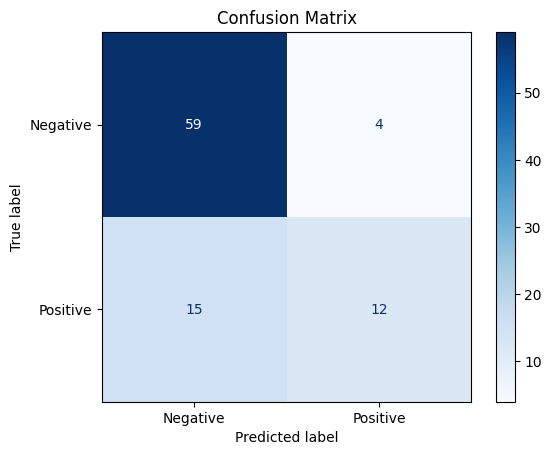


Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.94      0.86        63
    Positive       0.75      0.44      0.56        27

    accuracy                           0.79        90
   macro avg       0.77      0.69      0.71        90
weighted avg       0.78      0.79      0.77        90

Number of selected features: 75
Shape of SHAP values: (245, 75)


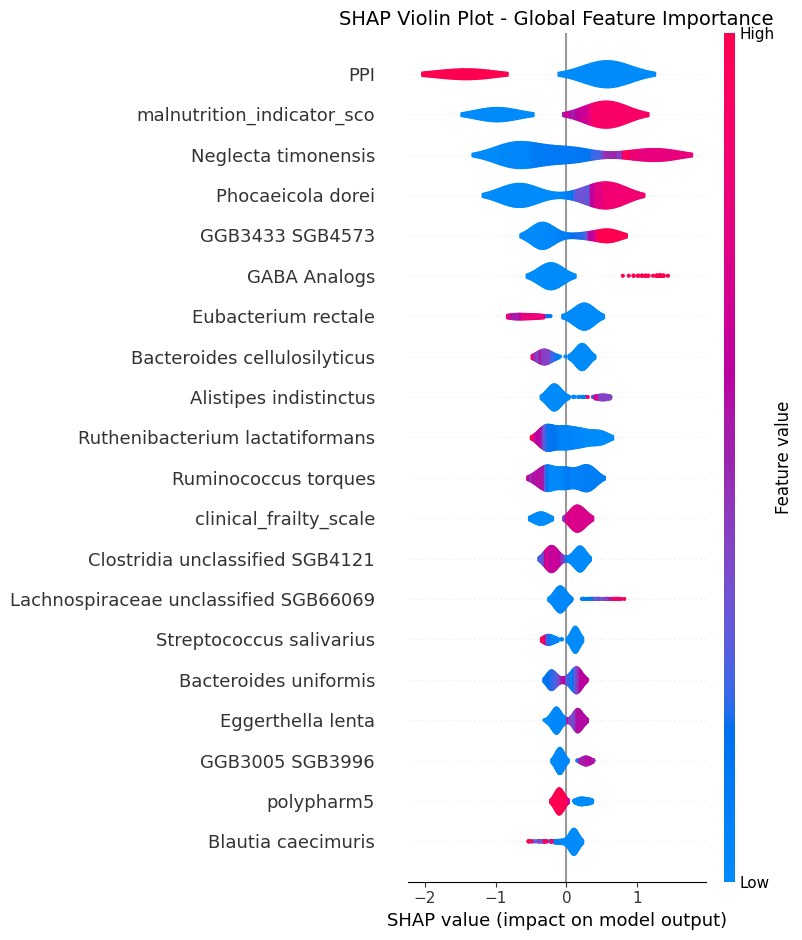

Overlap bacteria found: {'Bacteroides_uniformis', 'Bacteroides_caccae', 'Ruminococcaceae_bacterium', 'Alistipes_shahii', 'GGB9694_SGB15204', 'Intestinimonas_butyriciproducens', 'Neglecta_timonensis', 'GGB9615_SGB15053', 'Dialister_invisus', 'Clostridium_sp_AF34_10BH', 'Streptococcus_salivarius', 'Eggerthella_lenta', 'Akkermansia_sp_BIOML_A40', 'Akkermansia_muciniphila', 'Megasphaera_sp_MJR8396C', 'Bariatricus_massiliensis', 'Sellimonas_intestinalis', 'Bacteroides_ovatus', 'Ruminococcus_gnavus', 'Ruminococcus_torques', 'Catabacter_hongkongensis', 'Alistipes_finegoldii', 'Ruminococcaceae_unclassified_SGB15260', 'Blautia_caecimuris', 'Negativibacillus_massiliensis', 'Enterocloster_bolteae', 'Lachnospiraceae_unclassified_SGB66069', 'Evtepia_gabavorous', 'Faecalibacterium_prausnitzii', 'Faecalimonas_umbilicata', 'Parabacteroides_goldsteinii', 'Klebsiella_pneumoniae', 'Bacteroides_cellulosilyticus', 'GGB4566_SGB6305', 'GGB3293_SGB4348', 'GGB3433_SGB4573', 'Alistipes_onderdonkii', 'GGB9557_SG

In [14]:
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix, 
    classification_report, ConfusionMatrixDisplay
)

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# Constants and Configuration
print(f"Experiment number: {experiment_number} | Seed number: {seed}")
# seed = experiment_seed  # Replace with your experiment seed
test_size = 0.25
gpu_device = "hist"

# Function to check for overlaps between train and test data
def check_for_overlap(train_data, test_data):
    """
    Checks for overlapping Sample ID and study_id between train and test datasets.
    """
    # Check for overlapping Study IDs
    overlap_study_ids = set(train_data["study_id"]) & set(test_data["study_id"])
    if overlap_study_ids:
        print(f"Overlap Study ID found: {overlap_study_ids}")
    else:
        print("No overlap Study ID found.")

    # Check for overlapping Sample IDs
    overlap_sample_ids = set(train_data["Sample ID"]) & set(test_data["Sample ID"])
    if overlap_sample_ids:
        print(f"Overlap Sample ID found: {overlap_sample_ids}")
    else:
        print("No overlap Sample ID found.")

def check_for_bacteria(list_a, list_b):
    """
    Checks for overlapping bactertia from list_a and list list_b database and predicted bacteria.
    """
    # Check for overlapping Study IDs
    list_a = [item.replace(" ", "_") for item in list_a]
    list_b = [item.replace(" ", "_") for item in list_b]
    
    overlap_bacteria = set(list_a) & set(list_b)
    if overlap_bacteria:
        print(f"Overlap bacteria found: {overlap_bacteria}")
    else:
        print("No overlap bacteria found.")
    return overlap_bacteria

        
def preprocess_data(df, columns_to_drop, test_size, seed):
    # Split study IDs into train/test sets
    study_labels = df.groupby("study_id")["Alzheimers"].max().reset_index()
    train_ids, test_ids = train_test_split(
        study_labels["study_id"],
        test_size=test_size,
        stratify=study_labels["Alzheimers"],
        random_state=seed,
    )
    
    train_data = df[df["study_id"].isin(train_ids)].copy()
    test_data = df[df["study_id"].isin(test_ids)].copy()

    # Check for overlaps
    check_for_overlap(train_data, test_data)
    
    # Select feature columns
    feature_columns = [col for col in df.columns if col not in columns_to_drop]

    # Convert feature columns to float64 to ensure compatibility
    train_data[feature_columns] = train_data[feature_columns].astype(np.float64)
    test_data[feature_columns] = test_data[feature_columns].astype(np.float64)

    # Normalize the feature columns
    scaler = StandardScaler()
    train_data.loc[:, feature_columns] = scaler.fit_transform(train_data[feature_columns])
    test_data.loc[:, feature_columns] = scaler.transform(test_data[feature_columns])

    return train_data, test_data, feature_columns

# Function to compute class weights
def compute_weights(y_train):
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0]
    return scale_pos_weight

# Define Optuna Objective Function
def objective(trial, X_train, y_train, scale_pos_weight, seed):
    print(f"Seed in the model {seed} on Device {device}")
    # Feature selection parameters
    threshold = trial.suggest_categorical('threshold', ['median', 'mean', '0.5*mean', '1.5*mean', 'very_low'])
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])
    norm_order = trial.suggest_int('norm_order', 1, 2)
    threshold_value = -1e10 if threshold == 'very_low' else threshold

    # Feature selection
    selector = SelectFromModel(
        estimator=XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight= scale_pos_weight,
            random_state=seed,
            tree_method=gpu_device, 
            device=device
        ),
        threshold=threshold_value,
        max_features=max_features,
        norm_order=norm_order
    )
    
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)

    # Define XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,
        'seed': seed,
        'tree_method': gpu_device,
        'device': device
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train_selected, y_train):
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=trial.suggest_int("n_estimators", 50, 300),
            evals=[(dtrain, 'train'), (dval, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        y_val_pred = model.predict(dval)
        y_val_pred_binary = (y_val_pred >= 0.5).astype(int)
        f1_scores.append(f1_score(y_val_fold, y_val_pred_binary))
    return np.mean(f1_scores)

# Main Program
columns_to_drop = ["Sample ID", "study_id", "Alzheimers", "Date Sample", "age", "Dementia Other"] # "malnutrition_indicator_sco", "clinical_frailty_scale", "PPI", 

train_data, test_data, feature_columns = preprocess_data(clinical_microbiome_df, columns_to_drop, test_size, seed)
X_train = deepcopy(train_data[feature_columns].values)
y_train = np.array(train_data["Alzheimers"].values)
X_test = deepcopy(test_data[feature_columns].values)
y_test = np.array(test_data["Alzheimers"].values)
scale_pos_weight = compute_weights(y_train)

# Run Optuna Optimization
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=seed))
study.optimize(lambda trial: objective(trial, X_train, y_train, scale_pos_weight, seed), n_trials=100)

# Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Apply Final Model
final_selector = SelectFromModel(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=seed,
        tree_method=gpu_device,
        device=device,
        scale_pos_weight=scale_pos_weight
    ),
    
    threshold=-1e10 if best_params['threshold'] == 'very_low' else best_params['threshold'],
    max_features=best_params['max_features'],
    norm_order=best_params['norm_order']
)

final_selector.fit(X_train, y_train)
X_train_selected = final_selector.transform(X_train)
X_test_selected = final_selector.transform(X_test)

# Train Final Model
final_model_params = {
    **{k: v for k, v in best_params.items() if k not in ['threshold', 'norm_order', 'max_features', 'n_estimators']},
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'seed': seed,
    'tree_method': gpu_device,
    'device': device
}

dtrain_final = xgb.DMatrix(X_train_selected, label=y_train)
dtest_final = xgb.DMatrix(X_test_selected)

final_model = xgb.train(
    params=final_model_params,
    dtrain=dtrain_final,
    num_boost_round=best_params['n_estimators'],
)

# Predictions and Evaluation
y_test_pred = final_model.predict(dtest_final)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
auc = roc_auc_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print("\nTest Metrics:")
print(f"ROC AUC: {auc}\nAccuracy: {accuracy}\nF1 Score: {f1}\nConfusion Matrix:\n{conf_matrix}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_test_pred_binary, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(report)

# Extract feature names for selected features
selected_feature_names = [feature_columns[i] for i in final_selector.get_support(indices=True)]
print(f"Number of selected features: {len(selected_feature_names)}")

# Step 1: Initialize SHAP explainer
explainer = shap.Explainer(final_model, X_train_selected)

# Step 2: Compute SHAP values
shap_values = explainer(X_train_selected, check_additivity=False)

# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [15]:
auc

np.float64(0.8712522045855379)

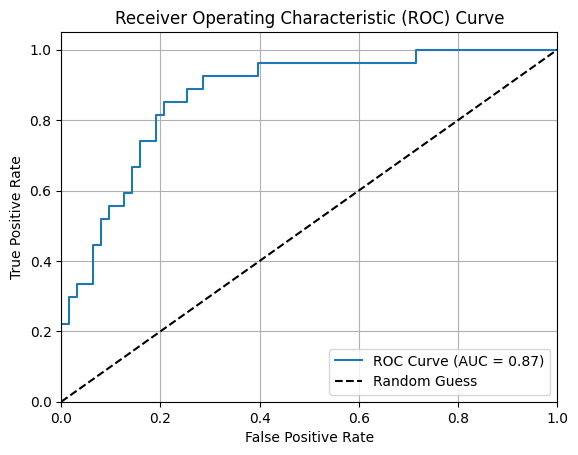

In [16]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [17]:
accuracy

0.7888888888888889

In [18]:
f1

np.float64(0.5581395348837209)

In [19]:
conf_matrix

array([[59,  4],
       [15, 12]])

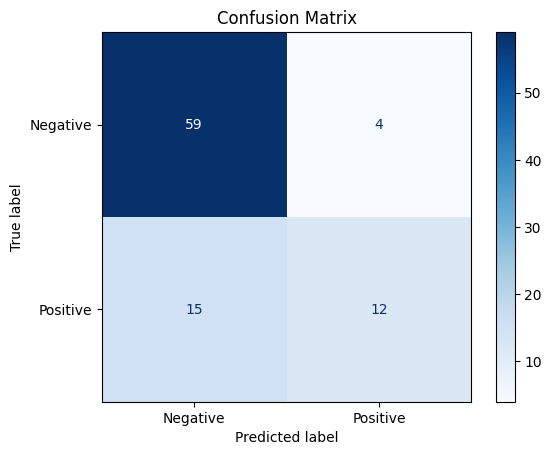

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

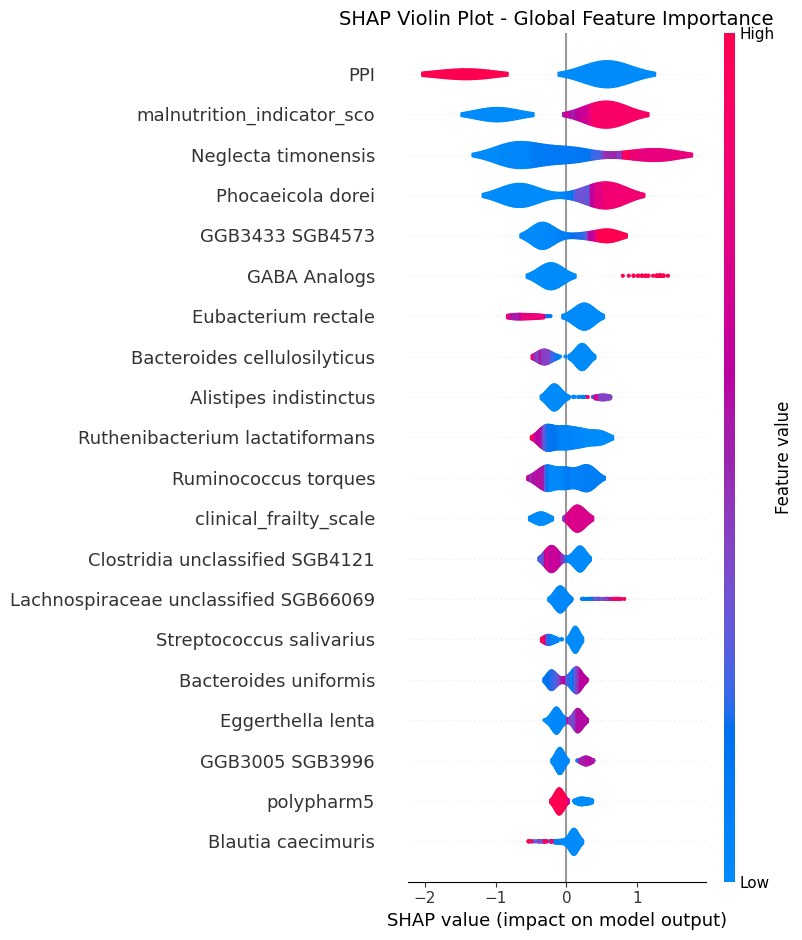

Overlap bacteria found: {'Bacteroides_uniformis', 'Bacteroides_caccae', 'Ruminococcaceae_bacterium', 'Alistipes_shahii', 'GGB9694_SGB15204', 'Intestinimonas_butyriciproducens', 'Neglecta_timonensis', 'GGB9615_SGB15053', 'Dialister_invisus', 'Clostridium_sp_AF34_10BH', 'Streptococcus_salivarius', 'Eggerthella_lenta', 'Akkermansia_sp_BIOML_A40', 'Akkermansia_muciniphila', 'Megasphaera_sp_MJR8396C', 'Bariatricus_massiliensis', 'Sellimonas_intestinalis', 'Bacteroides_ovatus', 'Ruminococcus_gnavus', 'Ruminococcus_torques', 'Catabacter_hongkongensis', 'Alistipes_finegoldii', 'Ruminococcaceae_unclassified_SGB15260', 'Blautia_caecimuris', 'Negativibacillus_massiliensis', 'Enterocloster_bolteae', 'Lachnospiraceae_unclassified_SGB66069', 'Evtepia_gabavorous', 'Faecalibacterium_prausnitzii', 'Faecalimonas_umbilicata', 'Parabacteroides_goldsteinii', 'Klebsiella_pneumoniae', 'Bacteroides_cellulosilyticus', 'GGB4566_SGB6305', 'GGB3293_SGB4348', 'GGB3433_SGB4573', 'Alistipes_onderdonkii', 'GGB9557_SG

In [21]:
# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

Shape of SHAP values: (245, 75)


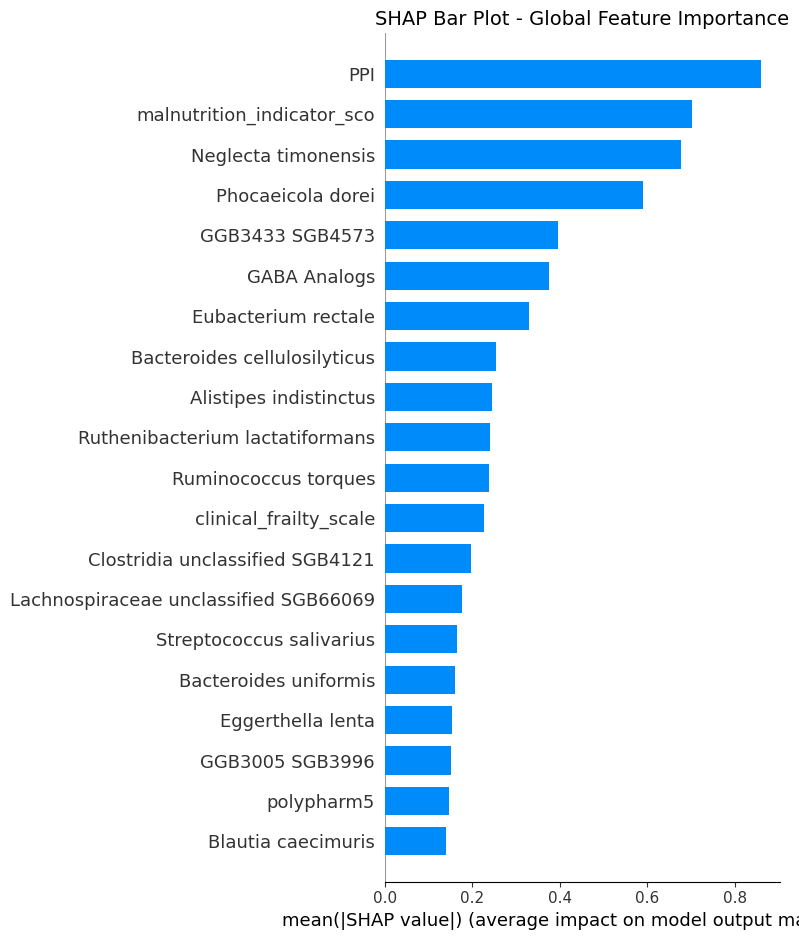

Overlap bacteria found: {'Bacteroides_uniformis', 'Bacteroides_caccae', 'Ruminococcaceae_bacterium', 'Alistipes_shahii', 'GGB9694_SGB15204', 'Intestinimonas_butyriciproducens', 'Neglecta_timonensis', 'GGB9615_SGB15053', 'Dialister_invisus', 'Clostridium_sp_AF34_10BH', 'Streptococcus_salivarius', 'Eggerthella_lenta', 'Akkermansia_sp_BIOML_A40', 'Akkermansia_muciniphila', 'Megasphaera_sp_MJR8396C', 'Bariatricus_massiliensis', 'Sellimonas_intestinalis', 'Bacteroides_ovatus', 'Ruminococcus_gnavus', 'Ruminococcus_torques', 'Catabacter_hongkongensis', 'Alistipes_finegoldii', 'Ruminococcaceae_unclassified_SGB15260', 'Blautia_caecimuris', 'Negativibacillus_massiliensis', 'Enterocloster_bolteae', 'Lachnospiraceae_unclassified_SGB66069', 'Evtepia_gabavorous', 'Faecalibacterium_prausnitzii', 'Faecalimonas_umbilicata', 'Parabacteroides_goldsteinii', 'Klebsiella_pneumoniae', 'Bacteroides_cellulosilyticus', 'GGB4566_SGB6305', 'GGB3293_SGB4348', 'GGB3433_SGB4573', 'Alistipes_onderdonkii', 'GGB9557_SG

In [22]:
# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Bar Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="bar"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [23]:
measures = ["xgboost", seed, experiment_number, accuracy, auc, f1]

# Create a DataFrame with appropriate column names
columns = ["Model", "Seed", "Experiment_Number", "Accuracy", "AUC", "F1_Score"]
measures_df = pd.DataFrame([measures], columns=columns)
measures_df

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,xgboost,1572185508,3,0.788889,0.871252,0.55814


In [24]:
output_path = "output"
measures_path = f"{output_path}{os.sep}xgboost_experiment{experiment_number:02d}_measures.csv"
if output_path and not os.path.exists(output_path):
    os.makedirs(output_path)
measures_path

'output/xgboost_experiment03_measures.csv'

In [25]:
measures_df.to_csv(measures_path, index=False)